# Group 55 Project Proposal: Type 2 Diabetes Based on Glucose and BMI 

### Introduction

**Relevant Background:** Type 2 diabetes is the result of one’s inability to properly use insulin when high levels of sugar are introduced to the body. Insulin is used to absorb glucose out of the blood system; however, if the body does not make any insulin, which is the case for patients with type 2 diabetes, the glucose levels may not be managed to a safe level. While type 2 diabetes is preventable, there are many factors that can induce the development of type 2 diabetes such as food intake, genetics, or weight.  

**Dataset Information:** The dataset we will be using includes the data for type 2 diabetic cases for female Pima Indian Heritage patients of at least 20 years of age. The dataset includes: 
- `Pregnancies`: number of times pregnant 
- `Glucose`: plasma glucose concentration results of a 2 hour oral glucose tolerance test 
- `BloodPressure`: diastolic blood pressure (mm Hg)
- `SkinThickness`: triceps skin fold thickness (mm) 
- `Insulin`: insulin levels in the blood (2-hour serum insulin (µ U/mL)
- `BMI`: weight in kg/(height in m)^2 
- `DiabetesPedigreeFunction`: the likelihood of getting type 2 diabetes
- `Age`: age in years
- `Outcome`: whether you have diabetes or not; either 1 (has type 2 diabetes) or 0 (doesn’t have type 2 diabetes). 

**Predictive Question:** Can we use a patient’s blood pressure and BMI measurements to predict if someone has type 2 diabetes? 

### Preliminary Exploratory Data Analysis

In [1]:
# installing libraries 
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [4]:
# importing data

diabetes <- read_csv("https://raw.githubusercontent.com/kzhang1223/dsci-100-2023s1-group-55/main/diabetes.csv") |>
        mutate(Outcome = as_factor(Outcome))

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
# table of data 
diabetes_split <- initial_split( diabetes, prop = 0.75, strata = Outcome)
diabetes_train <- training(diabetes_split) 
diabetes_test <- testing(diabetes_split)

diabetes_no_zeroes <- diabetes_train |> 
                filter(BloodPressure != 0, BMI != 0)


In [15]:

#Missing row count
diabetes_missing_rows <- diabetes_train |> 
            filter(BloodPressure == 0 | BMI == 0) |>
            summarize(count = n())

diabetes_missing_rows


#Number of Observations
diabetes_obs <- nrow(diabetes_no_zeroes)
diabetes_no_zeroes |>
  group_by(Outcome) |>
  summarize(
    count = n(),
    percentage = n() / diabetes_obs * 100)

#Mean of Predictors
avg_predict <- diabetes_no_zeroes |>
            select(BMI, BloodPressure) |>
            summarize(average_BMI = mean(BMI),
                      average_BP = mean(BloodPressure))

avg_predict


count
<int>
25


Outcome,count,percentage
<fct>,<int>,<dbl>
0,359,65.15426
1,192,34.84574


average_BMI,average_BP
<dbl>,<dbl>
32.45027,72.21053


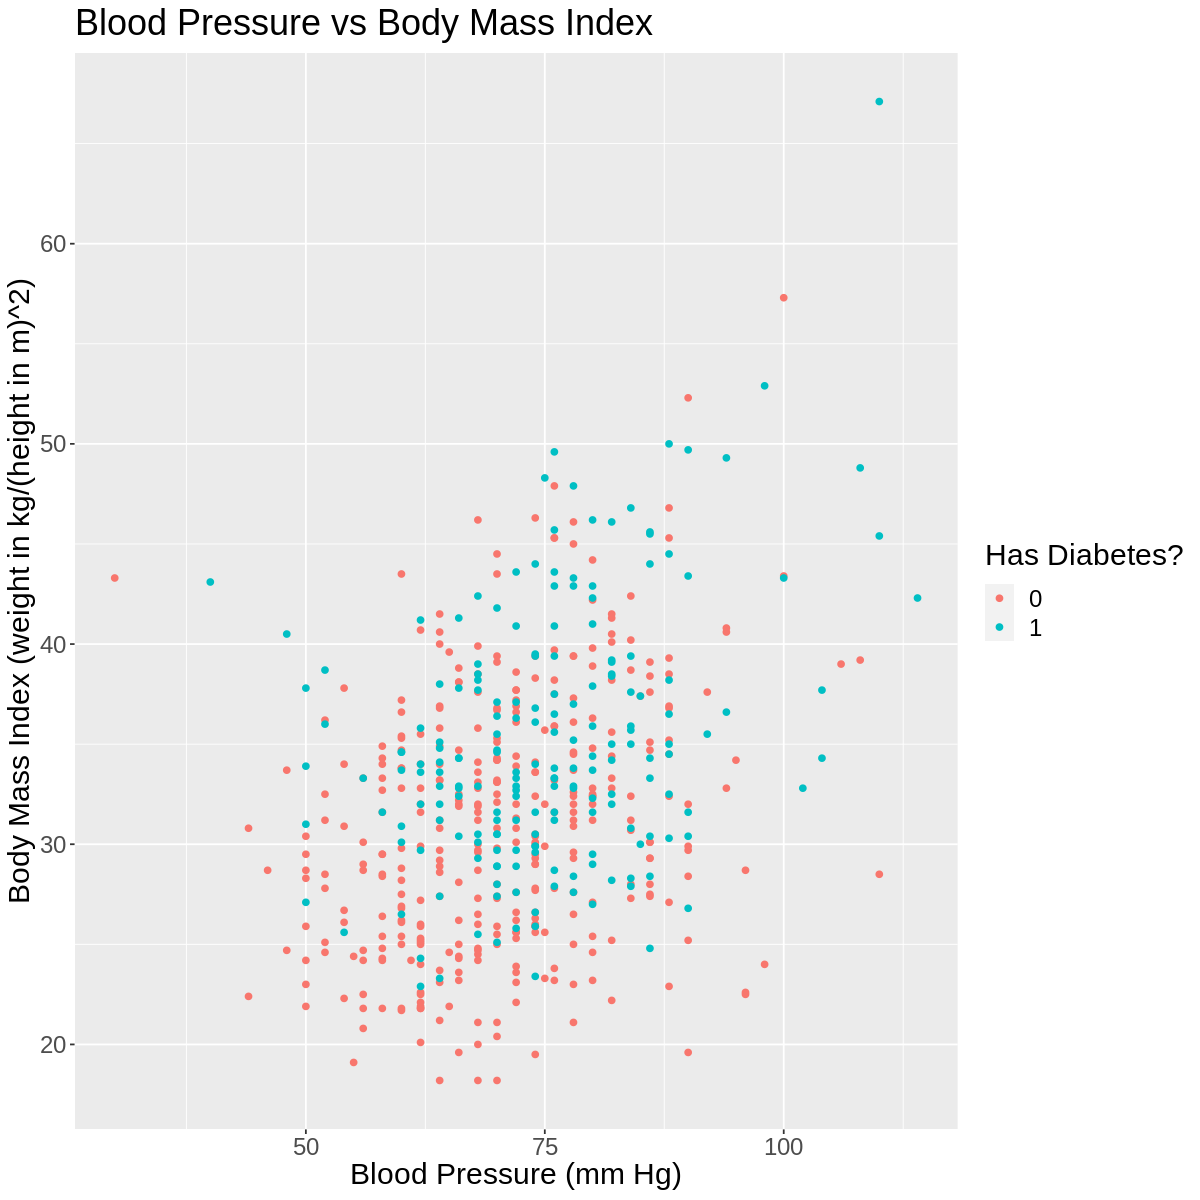

In [13]:
# visualizations
options(repr.plot.width = 10, repr.plot.height = 10)

diabetes_plot <- diabetes_no_zeroes |>
            ggplot(aes(x = BloodPressure, y = BMI)) + 
            geom_point(aes(color = Outcome)) +
            labs(x = "Blood Pressure (mm Hg)", y = "Body Mass Index (weight in kg/(height in m)^2)", color = "Has Diabetes?") +
            theme(text = element_text(size = 18)) + 
            ggtitle("Blood Pressure vs Body Mass Index") + 
            scale_fill_brewer(palette = 'Set2')

diabetes_plot

In [12]:
# distribution for blood pressure 
diabetes_bp <- diabetes_no_zeroes |>
            ggplot(aes(x = BloodPressure)) +
            geom_histogram(aes(fill = Outcome)) + 
            labs(x = "Blood Pressure (mm Hg)", y = "Number of People") +
            theme(text = element_text(size = 18)) + 
            facet_grid(rows = vars(Outcome))+
             scale_fill_brewer(palette = 'Set2')

In [11]:
# distribution for body mass index
diabetes_BMI <- diabetes_no_zeroes |>
    ggplot(aes(x = BMI, fill = Outcome))+
    geom_histogram()+
    facet_grid(rows = vars(Outcome))+
    labs(x = "Body Mass Index (weight in kg/(height in m)^2)",
         y = "Number of People")+
    theme(text = element_text(size = 18))+
    scale_fill_brewer(palette = 'Set2')

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



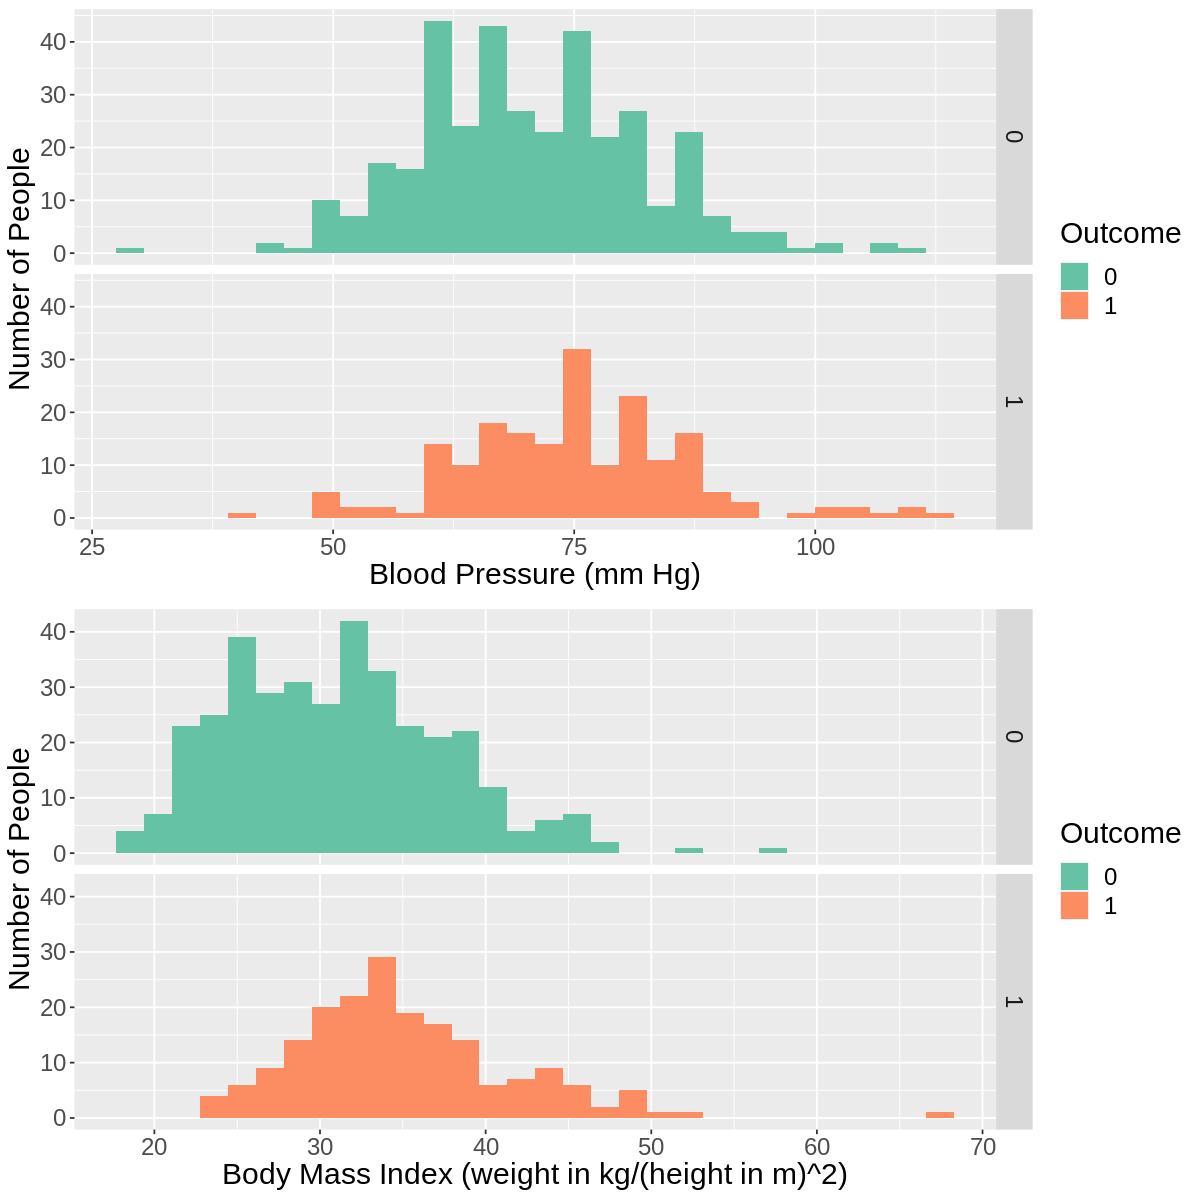

In [14]:
# visualization for comparison
diabetes_comparison <- plot_grid(diabetes_bp, diabetes_BMI, ncol = 1)
diabetes_comparison

### Methods

We will use the k-nearest neighbors classifier to create a model that will predict whether one has or does not have diabetes based on blood pressure and BMI. Through this model, we will use a 7-fold cross-validation to determine the best k value for the highest accuracy. This classifier would require high accuracy as diabetes should be treated before it becomes increasingly harmful. Inaccurate classifications of patients can lead to late treatment and/or unnecessary treatment for those who don’t actually have diabetes. 

One way we will visualize results is by using a scatter plot of blood pressure (x-axis) vs. BMI (y-axis) where each point’s color will be linked to the outcome of whether one has type 2 diabetes or not. Using this visualization, we will be able to see the relationship between glucose and BMI and how that affects the diagnosis of diabetes. 

### Expected Outcomes and Significance

We expect to find that there is a positive correlation between glucose and BMI resulting in type 2 diabetes. Since extra glucose can be stored in the body as fat and hence BMI, this could potentially lead to higher risks of type 2 diabetes. These findings could point to the prevention of type 2 diabetes which could help aid doctors in diagnosing patients accurately. These findings could potentially lead to questions regarding the susceptibility of type 2 diabetes based on other variables such as skin thickness. In addition to this, perhaps cases of type 2 diabetes in male Pima Indian heritage as well as other ethnicities could be examined. 

### Bibliography
Diabetes. (2022, September 16). World Health Organization (WHO). https://www.who.int/news-room/fact-sheets/detail/diabetes
Mehmet Akturk. (n.d.). Diabetes dataset. Kaggle: Your Machine Learning and Data Science Community. https://www.kaggle.com/datasets/mathchi/diabetes-data-set
Sigillito, V. (1990). (1990). Diabetes Dataset. [Data set]. NIDDK. https://www.kaggle.com/datasets/mathchi/diabetes-data-set